## Load Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import plot_roc_curve, roc_auc_score

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 17

## Load Data

In [3]:
pre_data = pd.read_csv('supp_data_3_rounded_deid_w_omicron.csv')
pre_data['Class'] = np.vectorize({'DELTA': 'COVID-19', 'OMICRON': 'COVID-19', 'NEGATIVE': 'No-Virus', 'N_GENE': 'COVID-19', 'OTHER_VIRUS': 'Other-Virus', 'POSITIVE': 'COVID-19', 'SPIKE_IN': 'No-Virus'}.get)(pre_data['Category'])
pre_data['Experiment'] = np.vectorize({1: 'Primary', 2: 'Variants', 3: 'Contamination', 4: 'Omicron'}.get)(pre_data['Experiment'])
pre_data.columns = np.char.strip(pre_data.columns.values.astype(str))

## Make ROC Curves

In [4]:
def plot_curve(comp, genes):
    
    # Determines the appropriate values for X and y:
    # 'nv' compares COVID against No-Virus
    # 'ov' compares COVID against Other-Virus
    # 'nvov' compares No-Virus against Other-Virus
    # 'cvno' compares COVID against No-Virus and Other-Virus
    # 'ovnc' compares Other-Virus against No-Virus and COVID
    
    data = pre_data[['Category', 'Experiment'] + genes].dropna(axis = 0, subset = genes)
    
    if comp == 'nv':
        filt = data[(data['Experiment'] == 'Primary') & ((data['Category'] == 'POSITIVE') | (data['Category'] == 'NEGATIVE'))]
        X = filt[genes].values
        y = (filt['Category'] == 'POSITIVE').values
        label = 'COVID+ vs. COVID-'
    elif comp == 'ov':
        filt = data[(data['Experiment'] == 'Primary') & ((data['Category'] == 'POSITIVE') | (data['Category'] == 'OTHER_VIRUS'))]
        X = filt[genes].values
        y = (filt['Category'] == 'POSITIVE').values
        label = 'COVID+ vs. Other-Virus'
    elif comp == 'nvov':
        filt = data[(data['Experiment'] == 'Primary') & ((data['Category'] == 'NEGATIVE') | (data['Category'] == 'OTHER_VIRUS'))]
        X = filt[genes].values
        y = (filt['Category'] == 'NEGATIVE').values
        label = 'COVID- vs. Other-Virus'
    elif comp == 'cvno':
        filt = data[(data['Experiment'] == 'Primary')]
        X = filt[genes].values
        y = (filt['Category'] == 'POSITIVE').values
        label = 'COVID+ vs. COVID- + Other-Virus'
    elif comp == 'ovnc':
        filt = data[(data['Experiment'] == 'Primary')]
        X = filt[genes].values
        y = (filt['Category'] == 'OTHER_VIRUS').values
        label = 'Other-Virus vs. COVID- + COVID+'
    else:
        return 0
    
    cv = StratifiedKFold(n_splits=5)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    seed = 8675309
    
    fig, ax = plt.subplots(figsize=(6, 6))
    cv_scores = np.zeros(len(y))
    for i, (train, test) in enumerate(cv.split(X, y)):
        
        scaler = StandardScaler()
        scaler.fit(X[train])
        X_sc = scaler.transform(X)
        classifier = SVC(kernel='linear', probability=True, random_state=seed)
        classifier.fit(X_sc[train], y[train])
        clf_scores = classifier.predict_proba(X_sc[test])[:, 1]
        cv_scores[test] = clf_scores
        viz = plot_roc_curve(classifier, X_sc[test], y[test], name='ROC fold {}'.format(i), alpha=0.3, lw=1, ax=ax)
        viz.line_.remove()
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'ROC (AUC = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
    
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    
    
    
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05]
           #, title='%s and %s, %s' % (genes[0], genes[1], label)
          )
    ax.legend(loc="lower right", prop={"size":13}, labelspacing=0.1)
    plt.xlabel('False Positive Rate', labelpad=10)
    plt.ylabel('True Positive Rate', labelpad=10)
    #plt.show()
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    
    # Uncomment to save figures and scores to files
    
    plt.savefig('%s (%s+%s) no title.pdf' % (label, genes[0], genes[1]), dpi = 200)
    #np.savetxt('%s (%s+%s).txt' % (label, genes[0], genes[1]), cv_scores)

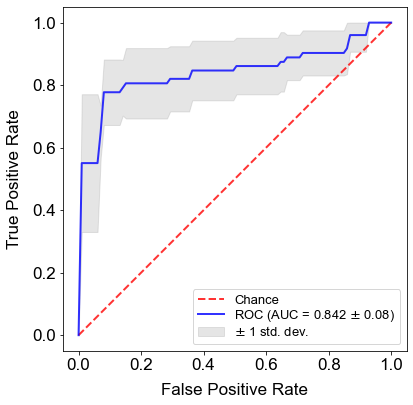

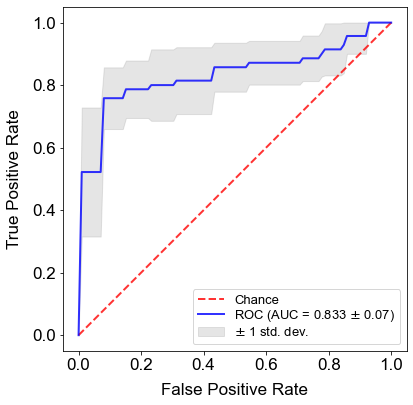

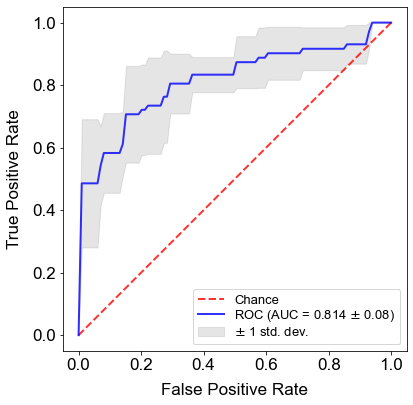

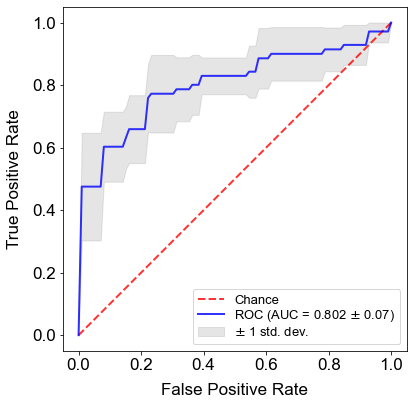

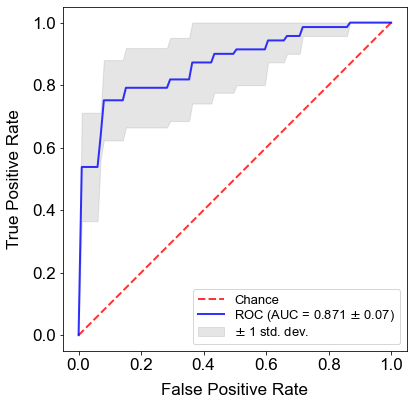

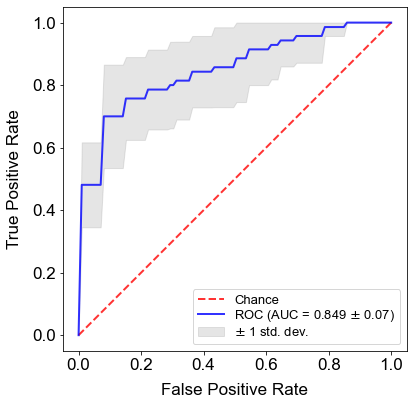

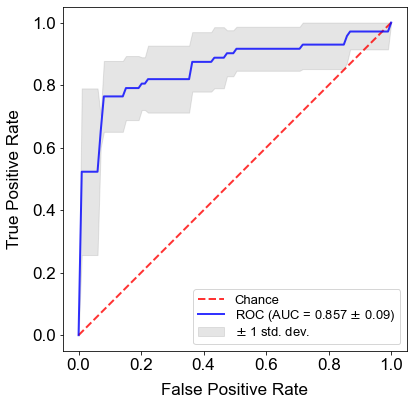

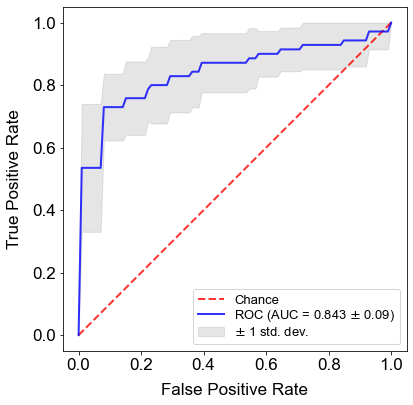

In [5]:
for one in ['IFI6', 'IFI27', 'IFI44', 'IFI44L']:
    for two in ['GBP5', 'CCL3']:
        plot_curve('nv', [one, two])

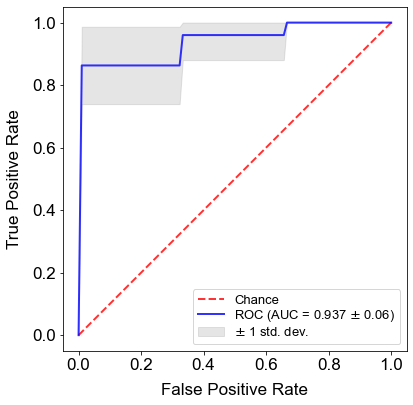

In [6]:
plot_curve('ov', ['IFI6', 'GBP5'])

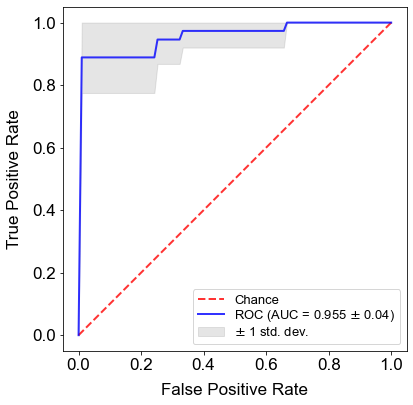

In [7]:
plot_curve('ov', ['IFI44', 'GBP5'])

In [8]:
def plot_curve_1g(comp, gene):
    
    # Determines the appropriate values for X and y:
    # 'nv' compares COVID against No-Virus
    # 'ov' compares COVID against Other-Virus
    # 'nvov' compares No-Virus against Other-Virus
    # 'cvno' compares COVID against No-Virus and Other-Virus
    # 'ovnc' compares Other-Virus against No-Virus and COVID
    
    data = pre_data[['Category', 'Experiment'] + gene].dropna(axis = 0, subset = gene)
    
    if comp == 'nv':
        filt = data[(data['Experiment'] == 'Primary') & ((data['Category'] == 'POSITIVE') | (data['Category'] == 'NEGATIVE'))]
        X = filt[gene].values
        y = (filt['Category'] == 'POSITIVE').values
        label = 'COVID+ vs. COVID-'
    elif comp == 'ov':
        filt = data[(data['Experiment'] == 'Primary') & ((data['Category'] == 'POSITIVE') | (data['Category'] == 'OTHER_VIRUS'))]
        X = filt[gene].values
        y = (filt['Category'] == 'POSITIVE').values
        label = 'COVID+ vs. Other-Virus'
    elif comp == 'nvov':
        filt = data[(data['Experiment'] == 'Primary') & ((data['Category'] == 'NEGATIVE') | (data['Category'] == 'OTHER_VIRUS'))]
        X = filt[gene].values
        y = (filt['Category'] == 'NEGATIVE').values
        label = 'COVID- vs. Other-Virus'
    elif comp == 'cvno':
        filt = data[(data['Experiment'] == 'Primary')]
        X = filt[gene].values
        y = (filt['Category'] == 'POSITIVE').values
        label = 'COVID+ vs. COVID- + Other-Virus'
    elif comp == 'ovnc':
        filt = data[(data['Experiment'] == 'Primary')]
        X = filt[gene].values
        y = (filt['Category'] == 'OTHER_VIRUS').values
        label = 'Other-Virus vs. COVID- + COVID+'
    else:
        return 0
    
    cv = StratifiedKFold(n_splits=5)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    seed = 8675309
    
    fig, ax = plt.subplots(figsize=(6, 6))
    cv_scores = np.zeros(len(y))
    for i, (train, test) in enumerate(cv.split(X, y)):
        
        scaler = StandardScaler()
        scaler.fit(X[train])
        X_sc = scaler.transform(X)
        classifier = SVC(kernel='linear', probability=True, random_state=seed)
        classifier.fit(X_sc[train], y[train])
        clf_scores = classifier.predict_proba(X_sc[test])[:, 1]
        cv_scores[test] = clf_scores
        viz = plot_roc_curve(classifier, X_sc[test], y[test], name='ROC fold {}'.format(i), alpha=0.3, lw=1, ax=ax)
        viz.line_.remove()
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'ROC (AUC = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
    
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    
    
    
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05]
           #, title='%s, %s' % (gene[0], label)
          )
    ax.legend(loc="lower right", prop={"size":13}, labelspacing=0.1)
    plt.xlabel('False Positive Rate', labelpad=10)
    plt.ylabel('True Positive Rate', labelpad=10)
    #plt.show()
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    
    # Uncomment to save figures and scores to files
    
    plt.savefig('%s (%s) no title.pdf' % (label, gene[0]), dpi = 200)
    #np.savetxt('%s (%s).txt' % (label, gene[0]), cv_scores)

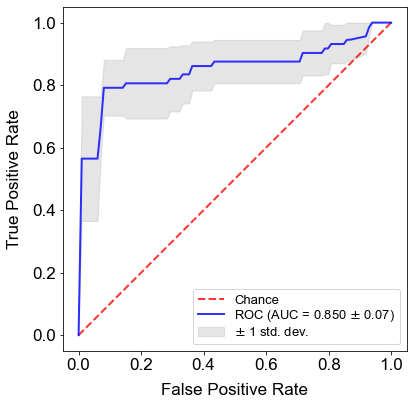

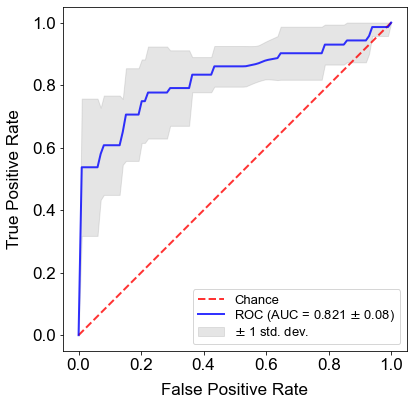

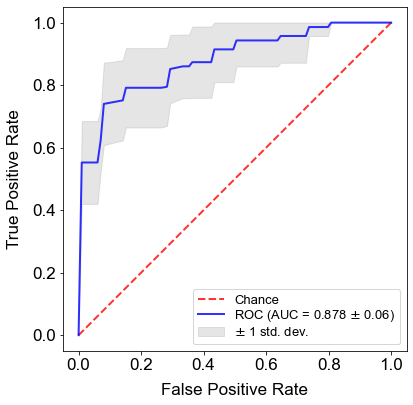

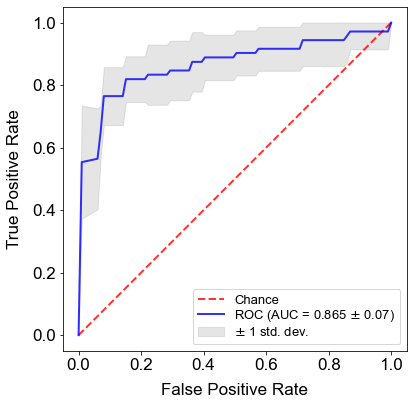

In [9]:
for one in ['IFI6', 'IFI27', 'IFI44', 'IFI44L']:
    plot_curve_1g('nv', [one])

## Apply Models to Variants and Spike-ins

In [10]:
data = pre_data
data = data.dropna(axis = 0, subset = ['IFI6', 'GBP5'])
filt = data[(data['Experiment'] == 'Primary') & ((data['Category'] == 'NEGATIVE') | (data['Category'] == 'POSITIVE'))]


In [11]:
# Uses the same CV loop and models generated by plot_curve to get COVID probability estimates for additional expression data.

def external_data(comp, ext):
    
    X = filt[['IFI6', 'GBP5']].values
    y = (filt['Category'] == 'POSITIVE').values
    
    cv = StratifiedKFold(n_splits=5)
    seed = 8675309
    cv_scores = np.zeros(len(y))
    ext_all_scores = []
    for i, (train, test) in enumerate(cv.split(X, y)):
        
        scaler = StandardScaler()
        scaler.fit(X[train])
        
        X_sc = scaler.transform(X)
        X_ext = scaler.transform(ext)
        
        classifier = SVC(kernel='linear', probability=True, random_state=seed)
        classifier.fit(X_sc[train], y[train])
        
        ext_scores = classifier.predict_proba(X_ext)[:, 1]
        ext_all_scores.append(ext_scores)
        
        cv_scores[test] = classifier.predict_proba(X_sc[test])[:, 1]
    print(np.average(ext_all_scores, axis = 0))
    return cv_scores, np.average(ext_all_scores, axis = 0)

In [12]:
#Calculate shifts for different sample categories

pri_negs_data_c = pre_data[(pre_data['Experiment'] == 'Primary')].iloc[np.isin(pre_data[(pre_data['Experiment'] == 'Primary')]['Swab_ID'], pre_data[(pre_data['Experiment'] == 'Contamination') & (pre_data['Category'] == 'NEGATIVE')]['Swab_ID'])]
con_negs_data = pre_data[(pre_data['Experiment'] == 'Contamination') & (pre_data['Category'] == 'NEGATIVE')]

pri_con_med_shift = np.median(con_negs_data[['IFI6', 'GBP5']].values - pri_negs_data_c[['IFI6', 'GBP5']].values, axis = 0)


pri_negs_data_v = pre_data[(pre_data['Experiment'] == 'Primary')].iloc[np.isin(pre_data[(pre_data['Experiment'] == 'Primary')]['Swab_ID'], pre_data[(pre_data['Experiment'] == 'Variants') & (pre_data['Category'] == 'NEGATIVE')]['Swab_ID'])]
var_negs_data = pre_data[(pre_data['Experiment'] == 'Variants') & (pre_data['Category'] == 'NEGATIVE')]

pri_var_med_shift = np.median(var_negs_data[['IFI6', 'GBP5']].values - pri_negs_data_v[['IFI6', 'GBP5']].values, axis = 0)


pri_negs_data_o = pre_data[(pre_data['Experiment'] == 'Primary')].iloc[np.isin(pre_data[(pre_data['Experiment'] == 'Primary')]['Swab_ID'], pre_data[(pre_data['Experiment'] == 'Omicron') & (pre_data['Category'] == 'NEGATIVE')]['Swab_ID'])]
omi_negs_data = pre_data[(pre_data['Experiment'] == 'Omicron') & (pre_data['Category'] == 'NEGATIVE')]

pri_omi_med_shift = np.median(omi_negs_data[['IFI6', 'GBP5']].values - pri_negs_data_o[['IFI6', 'GBP5']].values, axis = 0)




In [13]:
shift_data = pre_data[(pre_data['Experiment'] != 'Primary') | (pre_data['Category'] == 'N_GENE') | (pre_data['Category'] == 'OTHER_VIRUS')].copy()


shift_data.loc[shift_data['Experiment'] == 'Contamination', ['IFI6', 'GBP5']] -= pri_con_med_shift
shift_data.loc[shift_data['Experiment'] == 'Variants', ['IFI6', 'GBP5']] -= pri_var_med_shift
shift_data.loc[shift_data['Experiment'] == 'Omicron', ['IFI6', 'GBP5']] -= pri_omi_med_shift





In [14]:
#Get COVID probabilities

full_out = data[['Swab_ID', 'Class', 'Category', 'Experiment']].copy()

ext_data = shift_data.dropna(subset = ['IFI6', 'GBP5'])
int_scores, ext_scores = external_data('nv', ext_data[['IFI6', 'GBP5']])
full_out['COVID Probability'] = np.nan
full_out['COVID Probability'].loc[ext_data.index] = ext_scores
full_out['COVID Probability'].loc[filt.index] = int_scores
full_out.to_csv('COVID_Probability_Table.csv')

[0.3248257  0.42116405 0.3024227  0.36412213 0.25132138 0.34355386
 0.08480375 0.09754703 0.21833771 0.46990511 0.30732026 0.18826712
 0.40882414 0.38726808 0.1583003  0.18675368 0.17547628 0.08400651
 0.14688545 0.08736537 0.32885008 0.2443613  0.05770282 0.0639938
 0.29450566 0.29211652 0.11382523 0.64192572 0.73722574 0.30852501
 0.15341547 0.2253413  0.86741639 0.43221024 0.21511087 0.26312178
 0.43125336 0.46372575 0.15196192 0.32523235 0.12737404 0.30894943
 0.00670422 0.49061554 0.89442928 0.94944588 0.96104219 0.95615233
 0.97881287 0.99079002 0.96913125 0.99183637 0.96210373 0.94298977
 0.97881942 0.75323058 0.76673355 0.88940826]


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
